<a href="https://colab.research.google.com/github/NeuromatchAcademy/course-content/blob/main/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial2.ipynb" target="_blank"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/tutorials/W3D4_ReinforcementLearning/student/W3D4_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# Tutorial 2: Aprender a actuar: Bandidos multi-brazos

---

# Objetivos del tutorial

En este tutorial modelaremos los tipos más simples de agentes que actúan. Un agente actuante puede afectar la cantidad de recompensa que recibe, por lo que debe aprender a identificar las acciones que conducen a la mayor recompensa. Utilizará 'bandidos' para comprender los fundamentos de cómo interactúa una política con el algoritmo de aprendizaje en aprendizaje por refuerzo.

* Comprenderá el equilibrio fundamental entre exploración y explotación en una política.
* Comprenderás cómo interactúa la tasa de aprendizaje con la exploración para encontrar la mejor acción disponible.

---
# Configuración

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

##  Configuración de figuras


In [2]:
# @title Configuración de figuras
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

##  Funciones de graficado


In [3]:
# @title Funciones de graficado
np.set_printoptions(precision=3)

def plot_choices(q, epsilon, choice_fn, n_steps=1000, rng_seed=1):
  np.random.seed(rng_seed)
  counts = np.zeros_like(q)
  for t in range(n_steps):
    action = choice_fn(q, epsilon)
    counts[action] += 1

  fig, ax = plt.subplots()
  ax.bar(range(len(q)), counts/n_steps)
  ax.set(ylabel='% chosen', xlabel='action', ylim=(0,1), xticks=range(len(q)))
  plt.show()


def plot_multi_armed_bandit_results(results):
  fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15, 5))
  ax1.plot(results['rewards'])
  ax1.set(title=f"Total Reward: {np.sum(results['rewards']):.2f}",
          xlabel='step', ylabel='reward')
  ax2.plot(results['qs'])
  ax2.set(xlabel='step', ylabel='value')
  ax2.legend(range(len(results['mu'])))
  ax3.scatter(np.arange(len(results['mu'])),results['mu'], label='latent')
  ax3.scatter(np.arange(len(results['qs'][-1])), results['qs'][-1], label='learned')
  ax3.set(xlabel='action', ylabel='value')
  ax3.legend()
  plt.show()


def plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal):
  fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))

  ax1.plot(np.mean(trial_rewards, axis=1).T)
  ax1.set(title=f'Average Reward ({fixed})', xlabel='step', ylabel='reward')
  ax1.legend(labels)

  ax2.plot(np.mean(trial_optimal, axis=1).T)
  ax2.set(title=f'Performance ({fixed})', xlabel='step', ylabel='% optimal')
  ax2.legend(labels)
  plt.show()

---
# Sección 1: Bandidos multi-brazo

Considere el siguiente problema de aprendizaje. Te enfrentas repetidamente a una elección entre $k$ diferentes opciones o acciones. Después de cada elección, recibirá una señal de recompensa en forma de un valor numérico, donde cuanto mayor sea el valor, mejor. Su objetivo es maximizar la recompensa total esperada durante un período de tiempo, por ejemplo, sobre 1000 selecciones de acciones o pasos de tiempo.

Esta es la forma original del problema de los bandidos de k brazos. Este nombre deriva del nombre coloquial de una máquina tragamonedas, el "bandido manco", porque tiene una sola palanca para tirar y, a menudo, está manipulada para recibir más dinero del que paga con el tiempo. La extensión del bandido con múltiples brazos es imaginar, por ejemplo, que te enfrentas a varias máquinas tragamonedas en las que puedes jugar, pero solo una a la vez. ¿Qué máquina deberías jugar, es decir, qué brazo deberías tirar, qué acción deberías realizar, en un momento dado para maximizar tu pago total?

<img alt="MultiArmedBandit" width="625" height="269" src="https://github.com/NeuromatchAcademy/course-content/blob/main/tutorials/static/W3D4_Tutorial2_MultiarmedBandit.png?raw=true" >

Si bien existen muchos niveles diferentes de sofisticación y suposiciones sobre cómo se determinan las recompensas, aquí consideraremos el escenario simple en el que cada acción da como resultado una recompensa extraída de una distribución gaussiana diferente con media desconocida y varianza unitaria. Dado que cada acción está asociada con una recompensa media diferente, el objetivo del agente es encontrar la acción con la media más alta. Pero como las recompensas son ruidosas (las gaussianas correspondientes tienen una varianza unitaria), esas medias no pueden determinarse a partir de una única recompensa observada.

Esta configuración de problema se conoce como *entorno* o *ambiente* (_environment_). Resolveremos este *problema de optimización* con un *agente*, en este caso un algoritmo que recibe recompensas y devuelve acciones.

---
# Sección 2: Eligiendo una acción

Lo primero que nuestro agente debe poder hacer es elegir qué brazo tirar. La estrategia para elegir acciones basadas en nuestras expectativas se llama *política* (a menudo denominada $\pi$). Podríamos tener una política aleatoria (simplemente elegir un brazo al azar cada vez), aunque no parece probable que esto sea capaz de optimizar nuestra recompensa. Queremos cierta intencionalidad y, para lograrlo, necesitamos una forma de describir nuestras creencias sobre el potencial de recompensa de cada brazo. Hacemos esto con una función de valor de acción (_action-value function_).

\begin{equation}
q(a) = \mathbb{E} [r_{t} | a_ {t} = a]
\end{equation}

donde el valor $q$ por tomar la acción $a \in A$ en el momento $t$ es igual al valor esperado de la recompensa $r_t$ dado que tomamos la acción $a$ en ese momento. En la práctica, esto suele representarse como una matriz de valores, donde el valor de cada acción es un elemento diferente en la matriz.

Genial, ahora que tenemos una manera de describir nuestras creencias sobre los valores que cada acción debería devolver, elaboremos una política.

Una opción obvia sería realizar la acción con el mayor valor esperado. Esto se conoce como la política *codiciosa* (_greedy policy_)

\begin{equation}
a_{t} = \underset{a}{\operatorname{argmax}} \; q_{t} (a)
\end{equation}

donde nuestra acción de elección es la que maximiza la función de valor actual.

Hasta ahora todo bien, pero no puede ser tan fácil. Y, de hecho, la política codiciosa tiene un defecto fatal: fácilmente queda atrapada en máximos locales. Nunca explora para ver lo que no ha visto antes si una opción ya es mejor que las demás. Esto nos lleva a un desafío fundamental a la hora de idear políticas efectivas.

**El dilema explotación-exploración**

Si nunca intentamos nada nuevo, si siempre nos atenemos a la apuesta segura, no sabremos lo que nos estamos perdiendo. A veces no nos falta mucho de nada y nos arrepentimos de no habernos quedado con nuestra opción preferida, pero otras veces nos topamos con algo nuevo que era mucho mejor de lo que pensábamos.

Éste es el dilema explotación-exploración: ¿eliges ahora tu mejor opción o arriesgas la opción menos segura con la esperanza de encontrar algo mejor? Sin embargo, demasiada exploración significa que puedes terminar con una recompensa subóptima una vez que llegue el momento de detenerte.

Para evitar quedarse estancado en mínimos locales y al mismo tiempo maximizar la recompensa, las políticas eficaces necesitan alguna forma de equilibrar estos dos objetivos.

Una simple extensión de nuestra política codiciosa es agregar algo de aleatoriedad. Por ejemplo, al lanzar una moneda: cara elegimos la mejor opción ahora, cruz elegimos una al azar. Esto se conoce como la política $\epsilon$-codiciosa (_$\epsilon$-greedy policy_):

\begin{equation}
P (a_{t} = a) =
        \begin{cases}
        1 - \epsilon + \epsilon/N    & \quad \text{si } a_{t} = \underset{a}{\operatorname{argmax}}  \; q_{t} (a) \\
        \epsilon/N        & \quad \text{caso contrario}
        \end{cases}
\end{equation}

es decir, con probabilidad 1 - $\epsilon$ para $\epsilon \in [0,1]$ seleccionamos la opción codiciosa y, en caso contrario, seleccionamos una acción al azar (incluyendo la opción codiciosa).

A pesar de su relativa simplicidad, la política codiciosa de épsilon es bastante efectiva, lo que conduce a su popularidad.

### Ejercicio de programación 2: implementar Epsilon-Codicioso

*Referido en el video como Ejercicio 1*

En este ejercicio, implementará el algoritmo épsilon-codicioso para decidir qué acción realizar entre un conjunto de acciones posibles dada su función de valor y una probabilidad $\epsilon$ de simplemente elegir una al azar.

SUGERENCIA: Puede encontrar (https://numpy.org/doc/stable/reference/random/generated/numpy.random.random.html), [`np.random.choice`](https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html), and [`np.argmax`](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) útil aquí.

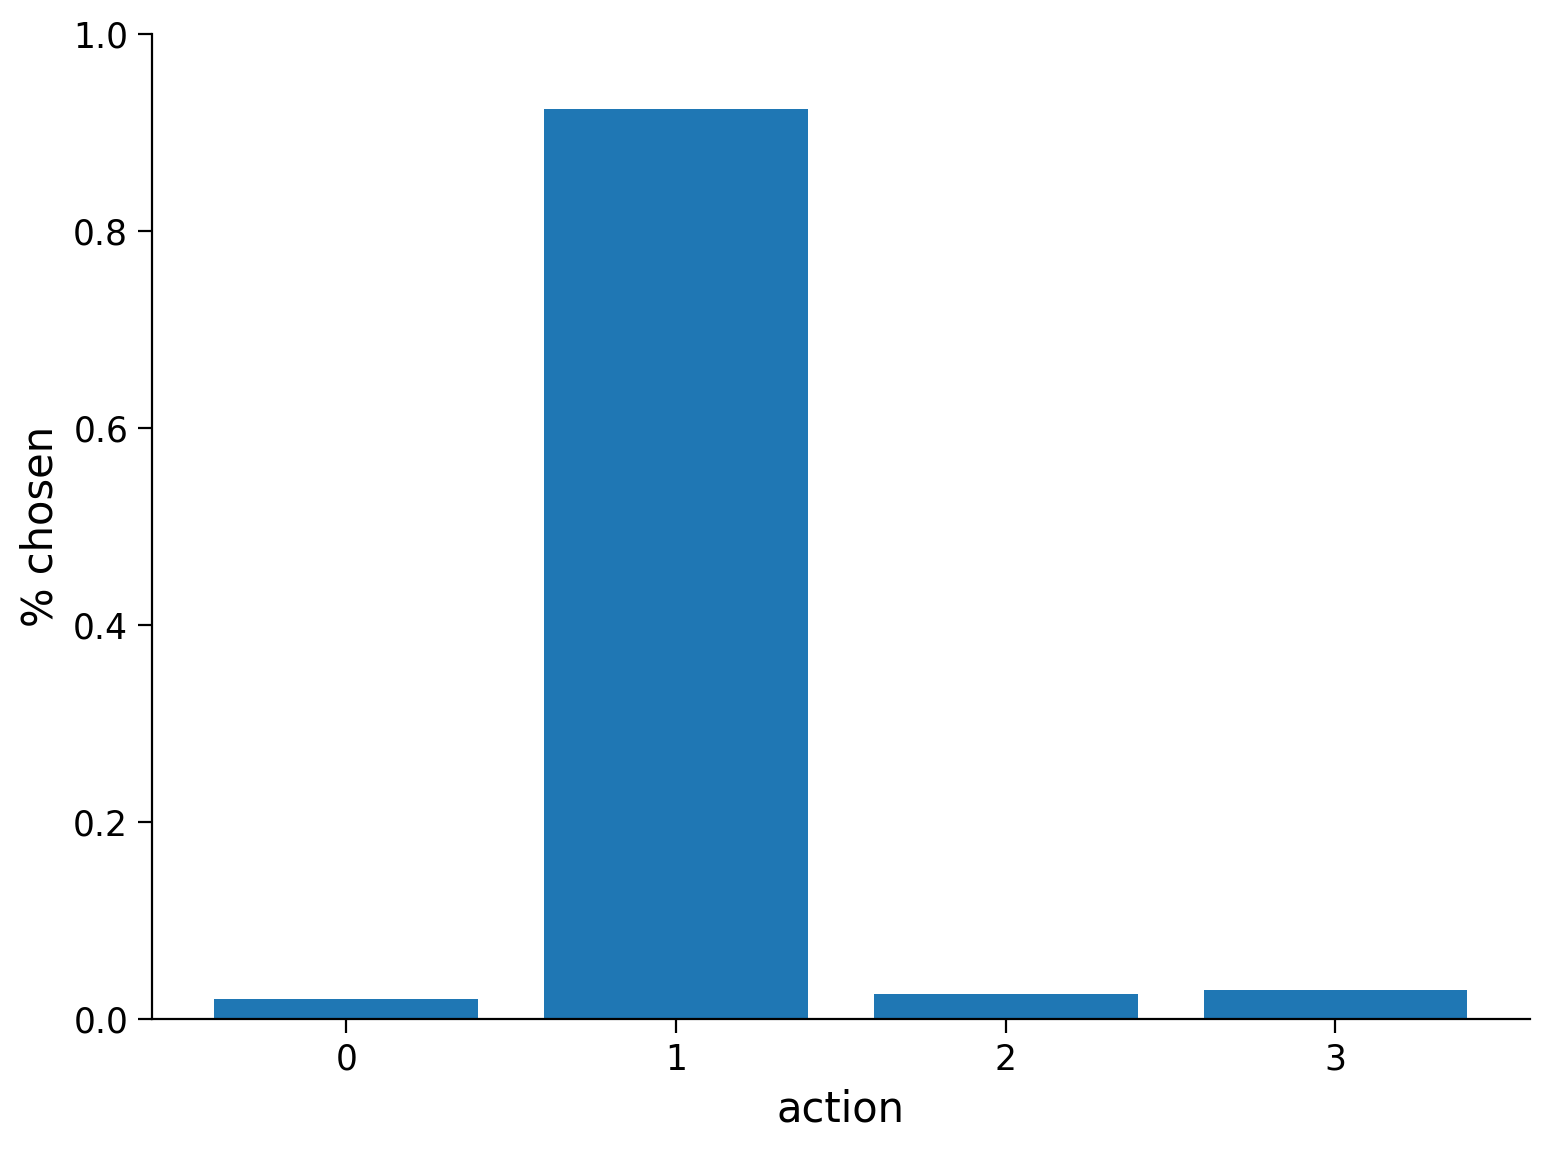

In [4]:
def epsilon_greedy(q, epsilon):
  """Epsilon-greedy policy: selects the maximum value action with probability
  (1-epsilon) and selects randomly with epsilon probability.

  Args:
    q (ndarray): an array of action values
    epsilon (float): probability of selecting an action randomly

  Returns:
    int: the chosen action
  """
  # write a boolean expression that determines if we should take the best action
  be_greedy = np.random.random() > epsilon

  if be_greedy:

    # write an expression for selecting the best action from the action values
    action = np.argmax(q)

  else:

    # write an expression for selecting a random action
    action = np.random.choice(len(q))

  return action


# Set parameters
q = [-2, 5, 0, 1]
epsilon = 0.1

# Visualize
plot_choices(q, epsilon, epsilon_greedy)

Esto es lo que deberíamos esperar, que la acción con el valor más grande (acción 1) se seleccione aproximadamente (1-$\epsilon$) del tiempo, o el 90% para $\epsilon = 0.1$, y el 10% restante sea dividir en partes iguales entre las otras opciones. Utilice la siguiente demo para explorar cómo el cambio de $\epsilon$ afecta la distribución de las acciones seleccionadas.

### Demo interactiva 2: Cambiando Epsilon

Epsilon es nuestro único parámetro para equilibrar la explotación y la exploración. Dado un conjunto de valores $q = [-2, 5, 0, 1]$, use el siguiente widget para ver cómo el cambio de $\epsilon$ influye en nuestra selección del valor máximo 5 (action = 1) vs los demás.

En los extremos de su rango (0 y 1), la política $\epsilon$-codiciosa reproduce otras dos políticas. ¿Cuales son?

¡Asegúrate de ejecutar esta celda para habilitar el widget!

In [5]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

@widgets.interact(epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0,
                                              description="ε"))
def explore_epilson_values(epsilon=0.1):
  q = [-2, 5, 0, 1]
  plot_choices(q, epsilon, epsilon_greedy, rng_seed=None)

interactive(children=(FloatSlider(value=0.1, description='ε', max=1.0), Output()), _dom_classes=('widget-inter…

---
# Sección 3: Aprendiendo de las recompensas

Ahora que tenemos una política para decidir qué hacer, ¿cómo aprendemos de nuestras acciones?

Una forma de hacerlo es simplemente mantener un registro de cada resultado que obtuvimos y usar los promedios para cada acción. Si tenemos un episodio potencialmente de larga duración, el costo computacional de mantener todos estos valores y volver a calcular la media una y otra vez no es ideal. En su lugar, podemos usar un cálculo de "media secuencial", que se ve así:

\begin{equation}
q_{t+1}(a) \leftarrow q_{t}(a) + \frac{1}{n_t} (r_{t} - q_{t}(a))
\end{equation}

donde nuestra función de valor de acción $q_t(a)$ es la media de las recompensas vistas hasta ahora, $n_t$ es el número de acciones realizadas por el tiempo $t$, y $r_t$ es la recompensa que acaba de recibir por tomar la acción $a$.

Esto todavía requiere que recordemos cuántas acciones hemos realizado, así que generalicemos esto un poco más y reemplacemos la acción total con un parámetro general $\alpha$, que llamaremos tasa de aprendizaje.

\begin{equation}
q_{t+1}(a) \leftarrow q_{t}(a) + \alpha (r_{t} - q_{t}(a))
\end{equation}

## Ejercicio de programación 3: Actualizando los valores de acción

*Referido en el video como Ejercicio 2*

En este ejercicio, implementará la regla de actualización del valor de acción mencionado anteriormente. La función incluirá la función de valor de acción representada como una matriz "q", la acción realizada, la recompensa recibida y la tasa de aprendizaje, "alpha". La función devolverá el valor actualizado para la acción de selección.

In [6]:
def update_action_value(q, action, reward, alpha):
  """ Compute the updated action value given the learning rate and observed
  reward.

  Args:
    q (ndarray): an array of action values
    action (int): the action taken
    reward (float): the reward received for taking the action
    alpha (float): the learning rate

  Returns:
    float: the updated value for the selected action
  """

  # Write an expression for the updated action value
  value = q[action] + alpha * (reward - q[action])

  return value


# Set parameters
q = [-2, 5, 0, 1]
action = 2
print(f"Original q({action}) value = {q[action]}")

# Update action
q[action] = update_action_value(q, 2, 10, 0.01)
print(f"Updated q({action}) value = {q[action]}")

Original q(2) value = 0
Updated q(2) value = 0.1


---
# Sección 4: Resolviendo bandidos multi-brazos

Ahora que tenemos una política y una regla de aprendizaje, podemos combinarlas para resolver nuestra tarea original de bandido con múltiples brazos. Recuerde que tenemos una cierta cantidad de brazos que otorgan recompensas extraídas de distribuciones gaussianas con media y varianza unitaria desconocidas, y nuestro objetivo es encontrar el brazo con la media más alta.

Primero, veamos cómo simularemos este entorno leyendo el código comentado a continuación.

In [7]:
def multi_armed_bandit(n_arms, epsilon, alpha, n_steps):
  """ Un bandido gaussiano multi-brazos que utiliza una política épsilon-codiciosa. Por cada
   acción, las recompensas se muestrean aleatoriamente a partir de una distribución normal, con una media
   asociada con ese brazo y varianza unitaria.

   Argumentos:
     n_arms (int): número de brazos o acciones
     épsilon (float): probabilidad de seleccionar una acción aleatoriamente
     alfa (float): la tasa de aprendizaje
     n_steps (int): número de pasos a evaluar

   Devuelve:
     dict: un diccionario que contiene los valores de acción, las acciones y las recompensas de
     la evaluación junto con los parámetros verdaderos del brazo mu y la optimalidad de
     las acciones elegidas.
  """
  # Gaussian bandit parameters
  mu = np.random.normal(size=n_arms)

  # Evaluation and reporting state
  q = np.zeros(n_arms)
  qs = np.zeros((n_steps, n_arms))
  rewards = np.zeros(n_steps)
  actions = np.zeros(n_steps)
  optimal = np.zeros(n_steps)

  # Run the bandit
  for t in range(n_steps):

    # Choose an action
    action = epsilon_greedy(q, epsilon)
    actions[t] = action

    # Compute rewards for all actions
    all_rewards = np.random.normal(mu)

    # Observe the reward for the chosen action
    reward = all_rewards[action]
    rewards[t] = reward

    # Was it the best possible choice?
    optimal_action = np.argmax(all_rewards)
    optimal[t] = action == optimal_action

    # Update the action value
    q[action] = update_action_value(q, action, reward, alpha)
    qs[t] = q

  results = {
      'qs': qs,
      'actions': actions,
      'rewards': rewards,
      'mu': mu,
      'optimal': optimal
  }

  return results

Podemos utilizar nuestro método de bandido multi-brazos para evaluar que tan bien funcionan nuestra política codiciosa de épsilon y nuestra regla de aprendizaje para resolver la tarea. Primero configuraremos nuestro entorno para que tenga 10 brazos y los parámetros de nuestro agente en $\epsilon=0.1$ y $\alpha=0.01$. Para tener una buena idea del desempeño del agente, ejecutaremos el episodio por 1000 pasos.

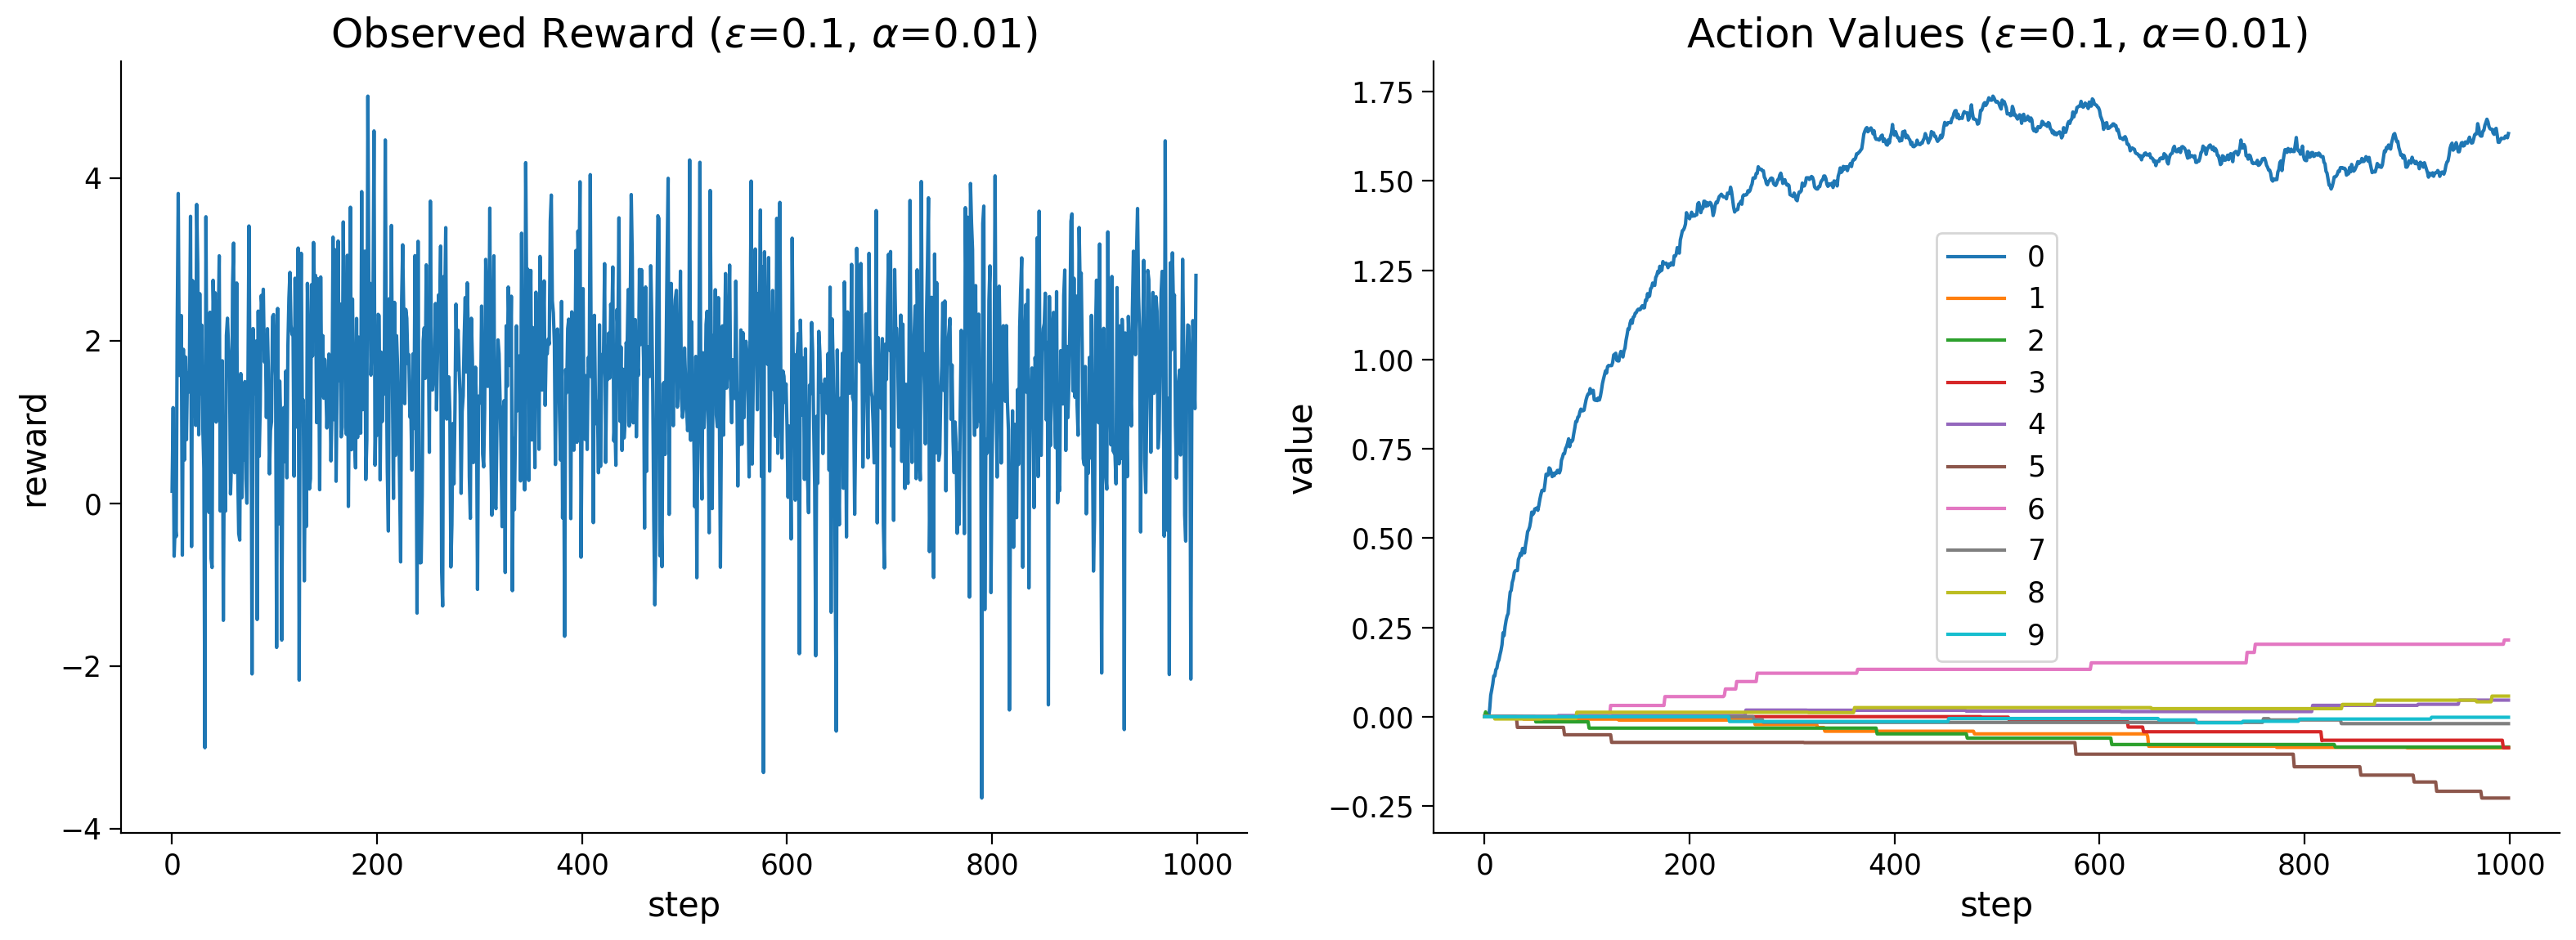

In [8]:
# @markdown Ejecutar para ver la visualización.

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

n_arms = 10
epsilon = 0.1
alpha = 0.01
n_steps = 1000

results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6))
ax1.plot(results['rewards'])
ax1.set(title=f'Observed Reward ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='reward')
ax2.plot(results['qs'])
ax2.set(title=f'Action Values ($\epsilon$={epsilon}, $\\alpha$={alpha})',
        xlabel='step', ylabel='value')
ax2.legend(range(n_arms))
plt.show(fig)

Muy bien, obtuvimos algunas recompensas que están por todas partes, pero el agente pareció instalarse en el primer brazo como la opción de acción preferida con relativa rapidez. Veamos qué tan bien lo hicimos recuperando las verdaderas medias de las variables aleatorias gaussianas detrás de los brazos.

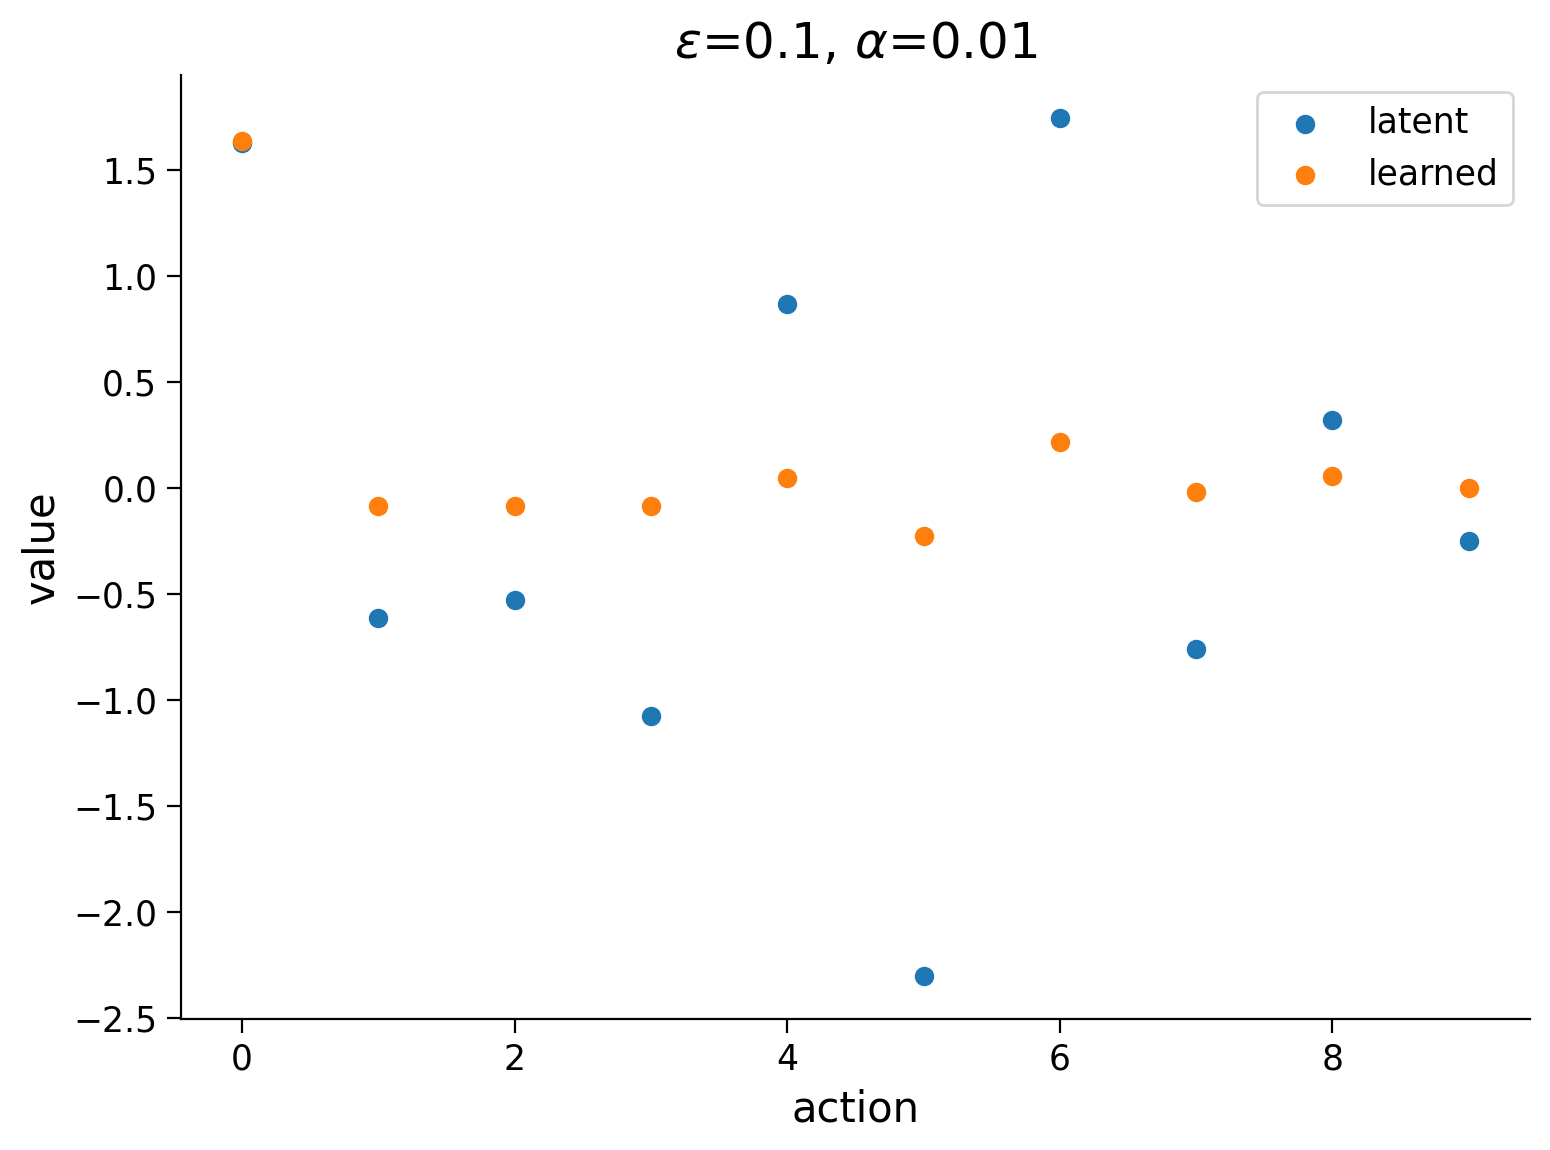

In [9]:
# @markdown Ejecutar para ver la visualización.

fig, ax = plt.subplots()
ax.scatter(np.arange(len(results['mu'])), results['mu'], label='latent')
ax.scatter(np.arange(len(results['qs'][-1])),results['qs'][-1], label='learned')
ax.set(title=f'$\epsilon$={epsilon}, $\\alpha$={alpha}',
       xlabel='action', ylabel='value')
ax.legend()
plt.show(fig)

Bueno, parece que hemos encontrado una muy buena estimación para la acción 0, pero la mayoría de las demás no son muy buenas. De hecho, podemos ver el efecto de la trampa de máximos locales en funcionamiento: la parte codiciosa de nuestro algoritmo bloqueada en la acción 0, que en realidad es la segunda mejor opción, debajo de la acción 6. Dado que estas son las medias de las variables aleatorias gaussianas, podemos ver que la superposición entre las dos sería bastante alta, por lo que incluso si exploráramos la acción 6, podríamos extraer una muestra que aún sea menor que nuestra estimación para la acción 0.

Sin embargo, esta fue sólo una elección de parámetros. ¿Quizás haya una mejor combinación?

## Demo interactiva 4: Cambiando de Epsilon y Alpha

Utilice el siguiente widget para explorar cómo la variación de los valores de $\epsilon$ (compensación de explotación-exploración), $\alpha$ (tasa de aprendizaje) e incluso el número de acciones $k$ cambia el comportamiento de nuestro agente.

In [10]:
# @markdown ¡Asegúrate de ejecutar esta celda para habilitar el widget!

@widgets.interact_manual(k=widgets.IntSlider(10, min=2, max=15),
                         epsilon=widgets.FloatSlider(0.1, min=0.0, max=1.0,
                                                     description="ε"),
                         alpha=widgets.FloatLogSlider(0.01, min=-3, max=0,
                                                      description="α"))
def explore_bandit_parameters(k=10, epsilon=0.1, alpha=0.001):
  results = multi_armed_bandit(k, epsilon, alpha, 1000)
  plot_multi_armed_bandit_results(results)

interactive(children=(IntSlider(value=10, description='k', max=15, min=2), FloatSlider(value=0.1, description=…

Si bien podemos ver cómo el cambio de los valores épsilon y alfa afecta el comportamiento del agente, esto no nos da una idea clara de qué combinación es óptima. Debido a la naturaleza estocástica tanto de nuestras recompensas como de nuestra política, una sola prueba no es suficiente para brindarnos esta información. Realicemos varias pruebas y comparemos el rendimiento promedio.

Primero veremos diferentes valores para $\epsilon \in [0.0, 0.1, 0.3]$ con un $\alpha=0.1$ fijo. Realizaremos 200 pruebas para lograr un buen equilibrio entre velocidad y precisión.

Ejecute esta celda para ver la visualización.

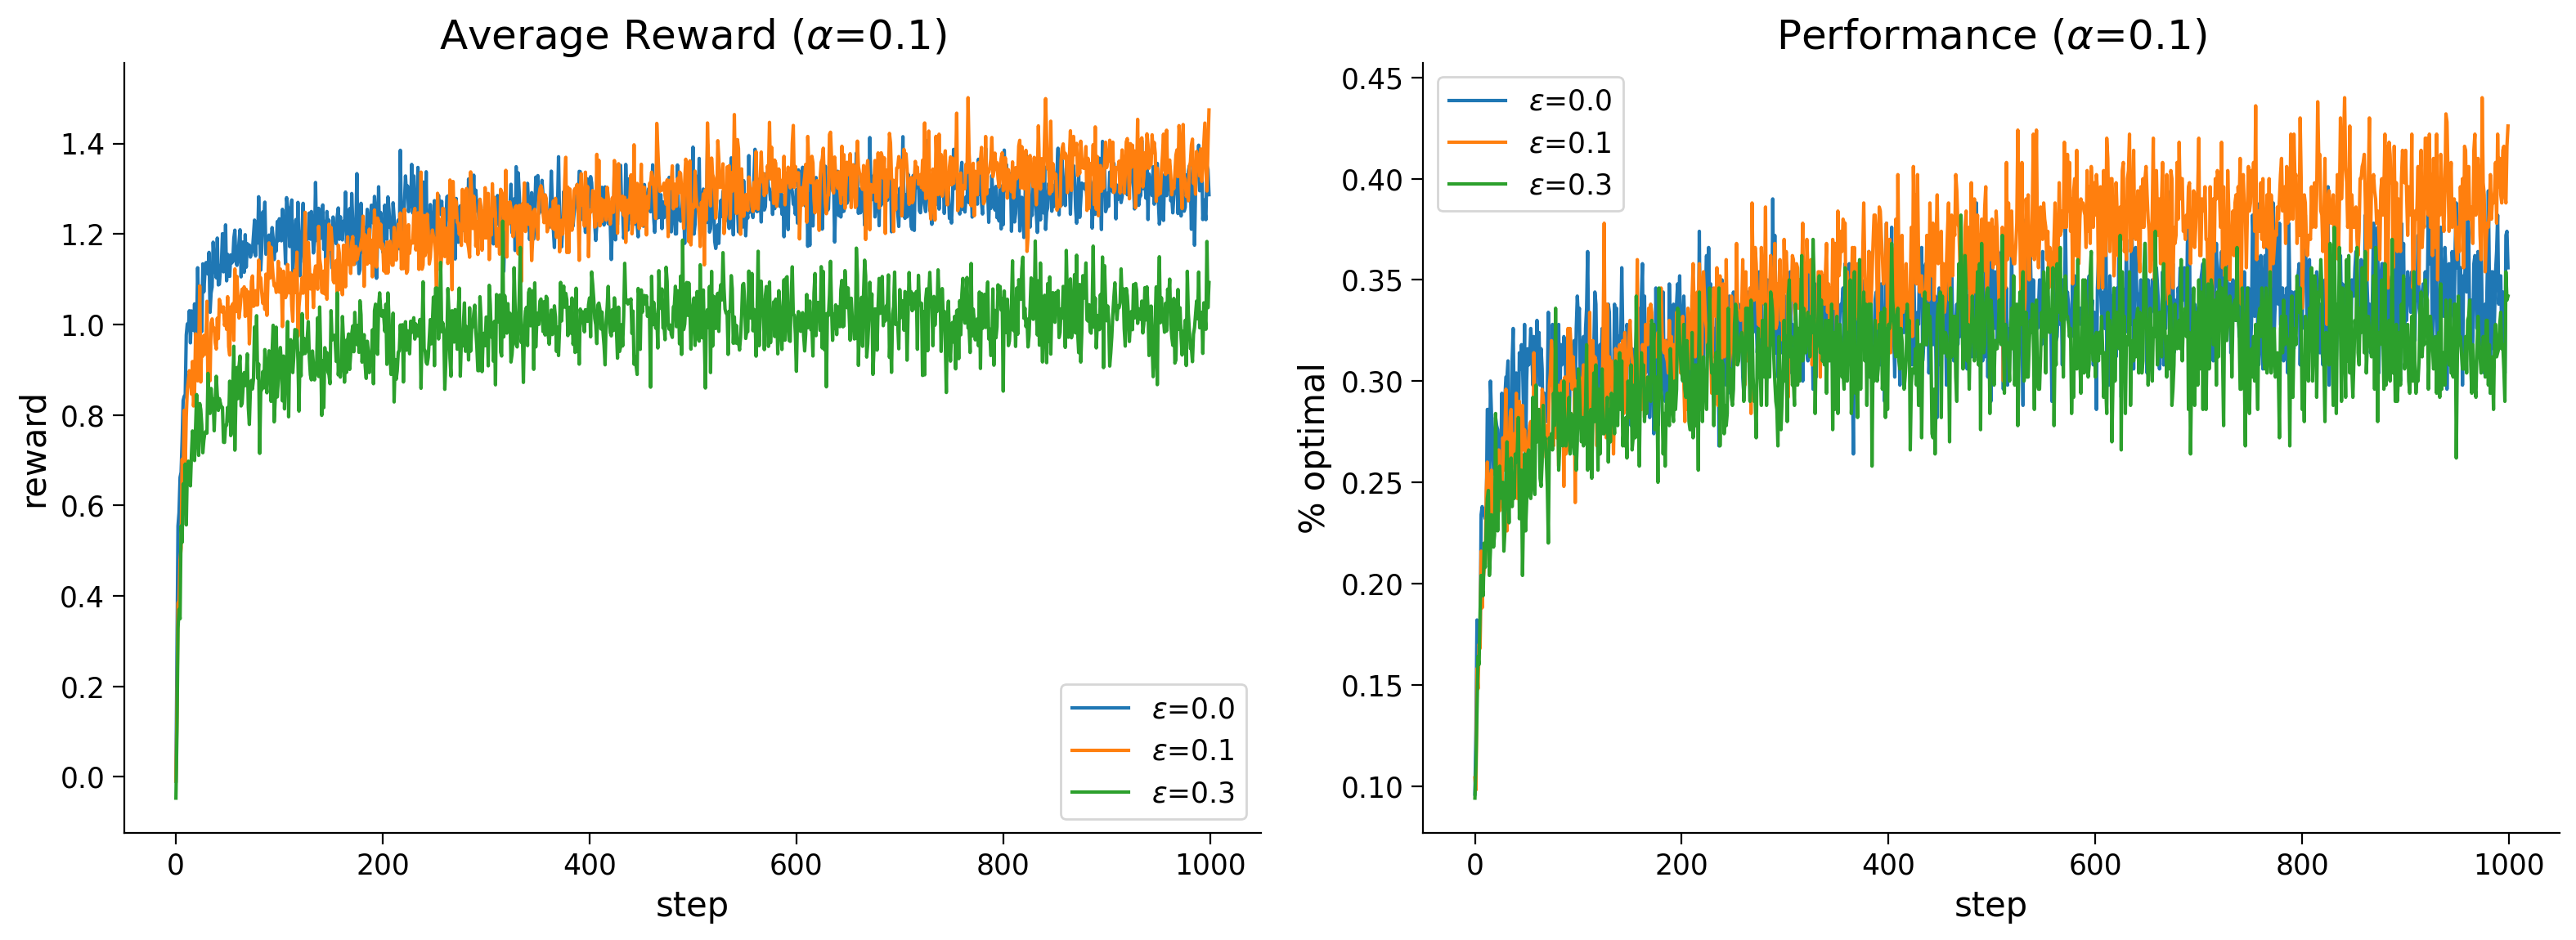

In [11]:
# @markdown Ejecute esta celda para ver la visualización.

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilons = [0.0, 0.1, 0.3]
alpha = 0.1
n_trials = 500
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, epsilon in enumerate(epsilons):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\epsilon$={e}' for e in epsilons]
fixed = f'$\\alpha$={alpha}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

A la izquierda hemos trazado la recompensa promedio a lo largo del tiempo, y vemos que si bien $\epsilon=0$ (la política codiciosa) funciona bien inicialmente, $\epsilon=0.1$ comienza a hacerlo ligeramente mejor a largo plazo, mientras que $ \epsilon=0.2$ tiene el peor rendimiento. Mirando a la derecha, vemos el porcentaje de veces que se tomó la acción óptima (la mejor opción posible en el momento $t$), y aquí nuevamente vemos un patrón similar de $\epsilon=0.1$ que comienza un poco más lento pero finalmente tener una ligera ventaja a largo plazo.

También podemos hacer lo mismo con las tasas de aprendizaje. Evaluaremos $\alpha \in [0.01, 0.1, 1.0]$ a un $\epsilon=0.1$ fijo.

Ejecute esta celda para ver la visualización.

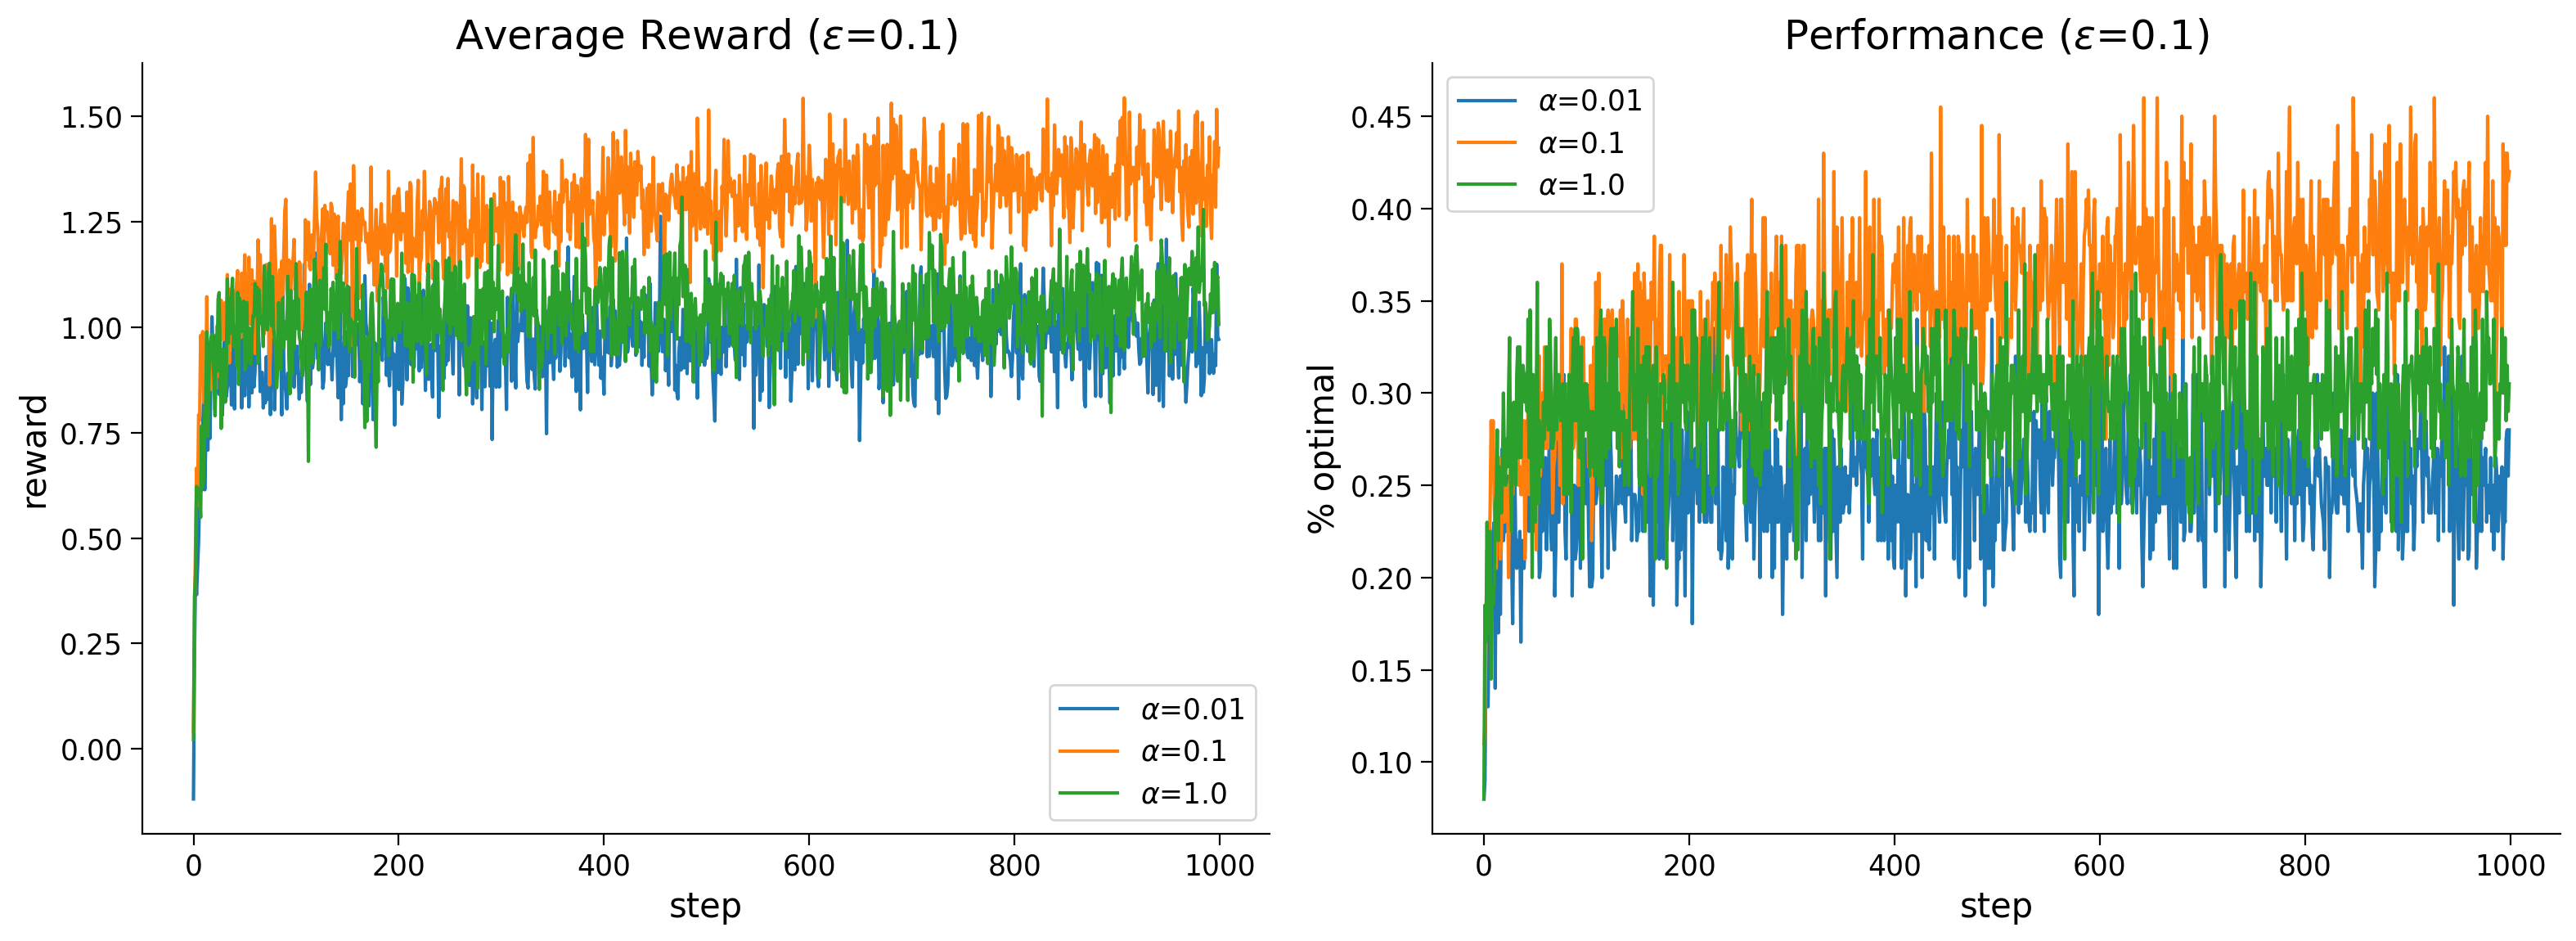

In [12]:
# @markdown Ejecute esta celda para ver la visualización.

# set for reproducibility, comment out / change seed value for different results
np.random.seed(1)

epsilon = 0.1
alphas = [0.01, 0.1, 1.0]
n_trials = 200
trial_rewards = np.zeros((len(epsilons), n_trials, n_steps))
trial_optimal = np.zeros((len(epsilons), n_trials, n_steps))
for i, alpha in enumerate(alphas):
  for n in range(n_trials):
    results = multi_armed_bandit(n_arms, epsilon, alpha, n_steps)
    trial_rewards[i, n] = results['rewards']
    trial_optimal[i, n] = results['optimal']

labels = [f'$\\alpha$={a}' for a in alphas]
fixed = f'$\epsilon$={epsilon}'
plot_parameter_performance(labels, fixed, trial_rewards, trial_optimal)

Nuevamente vemos un equilibrio entre una tasa de aprendizaje efectiva. $\alpha=0.01$ es demasiado débil para incorporar rápidamente buenos valores, mientras que $\alpha=1$ es demasiado fuerte, que probablemente genere una gran variación en los valores debido a la naturaleza gaussiana de las recompensas.

---
# Resumen


En este tutorial, implementó tanto el algoritmo de decisión épsilon-codicioso como una regla de aprendizaje para resolver un escenario de bandido multi-brazo. Viste cómo equilibrar la explotación y la exploración en la selección de acciones es fundamental para encontrar soluciones óptimas. También vio cómo la elección de una tasa de aprendizaje adecuada determina qué tan bien un agente puede generalizar la información que recibe de las recompensas.